# 1. Soft SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

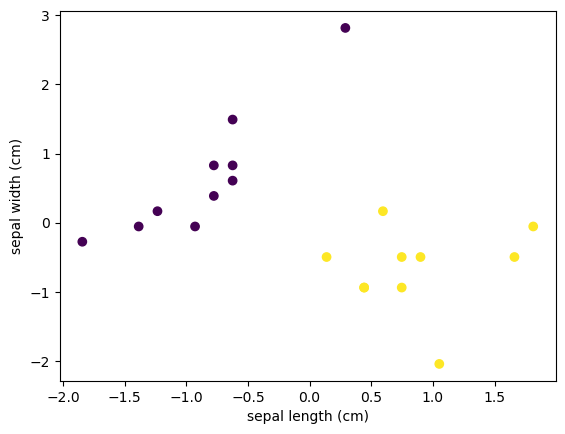

In [4]:
n = 20
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [5]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [6]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'a_{i}' for i in range(1,nx+1)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels, colors, adjusted_positions)):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    #plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Matrix G is not PSD, regularizing...
Time: 0.017267942428588867
Optimal objective value: -1.5032310356907104
SCS solver iterations: 200
SCS solve time: 0.001721838
SCS setup time: 0.00193607
Weight vector w: [ 1.57543151 -0.72420682]
Bias term b: 0.4240000088342713
Optimal value: -1.5032
Number of support vectors: 3
Dual variables (alpha): [ 1.50322792  0.09055491 -0.00000111 -0.00000212  0.00000197 -0.0000014
 -0.00000309 -0.00000182 -0.00000345 -0.00000289  0.00000161 -0.00000182
  0.0000009   1.41268727  0.00000102 -0.00000398  0.00000086  0.00000067
  0.00000164  0.00000607]
Constraints: [-1.503228   -0.09055491  0.00000111  0.00000212 -0.00000197  0.0000014
  0.00000309  0.00000182  0.00000345  0.00000289 -0.00000161  0.00000182
 -0.0000009  -1.4126873  -0.00000102  0.00000398 -0.00000086 -0.00000067
 -0.00000164 -0.00000607]


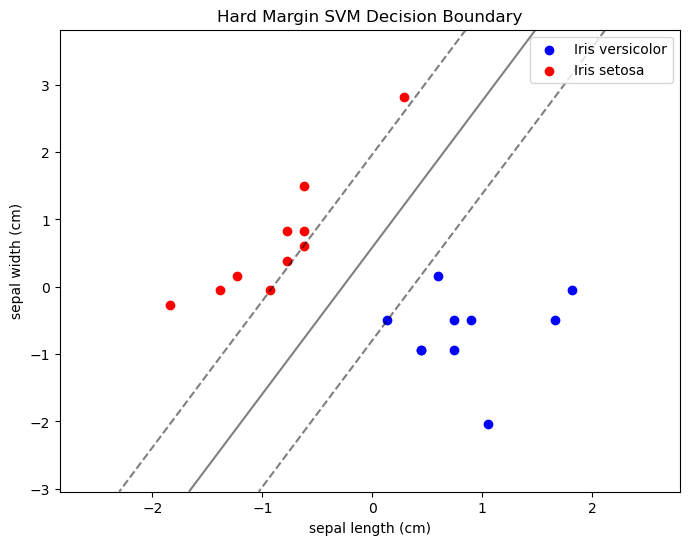

In [7]:
import cvxpy as cp
import numpy as np
import time

num_samples = selected_X.shape[0]
num_features = selected_X.shape[1]


# Define the dual variables
alpha = cp.Variable(num_samples)

# Kernel matrix (for linear kernel, it's just dot product of features)
K = selected_X @ selected_X.T

G = np.outer(selected_y, selected_y) * K # G_ij = y_i y_j K(x_i, x_j)

eigvals = np.linalg.eigvals(G)

if np.any(eigvals < 0):
    print("Matrix G is not PSD, regularizing...")
    G += np.eye(num_samples) * 1e-6 
    

objective = cp.Minimize((1/2) * cp.quad_form(alpha, G) - cp.sum(alpha))

# Define the constraints
constraints = [
    selected_y.T @ alpha == 0,
    alpha >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

def alpha_to_wb(alpha, X, y, epsilon=1e-4):
    w = np.sum(alpha.reshape(-1, 1) * y.reshape(-1, 1) * X, axis=0)

    # Find support vectors (points where 0 < alpha < C)
    support_vector_indices = np.where((alpha > epsilon))[0]
    n_support_vectors = len(support_vector_indices)
    
    if len(support_vector_indices) == 0:
        raise ValueError("No support vectors found. Try adjusting epsilon.")
    
    # Calculate b using the average over all support vectors
    b = 0
    for i in support_vector_indices:
        b += y[i] - np.dot(w, X[i])
    
    b /= len(support_vector_indices)
    
    return w, b, n_support_vectors
    
w_op, b_op, sv_op = alpha_to_wb(alpha.value, selected_X, selected_y)

print(f"Weight vector w: {w_op}")
print(f"Bias term b: {b_op}")

print(f"Optimal value: {problem.value:.4f}")
print(f"Number of support vectors: {np.sum(sv_op)}")

print('Dual variables (alpha):', alpha.value)

g_1 = jnp.array([-alpha.value[i] for i in range(alpha.value.shape[0])])

g_1 = g_1.reshape(-1, 1)
g_SCS = g_1.flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w_op, b_op, 0, 1)

In [8]:
nx = num_samples
nu = num_samples
nw = num_features
NY = nx + nu


A = jnp.array(selected_y.reshape(-1, 1).T)
b = jnp.zeros(1)

In [9]:
PM = A.T@jnp.linalg.inv(A@A.T)@A

def f(x):
    output = (1/2) * x.T @ G @ x - jnp.sum(x)
    return output

def g(x):    
    g_1 = [- x[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1)
    return output

def h(x):
    output = jnp.clip(A@x-b, a_min=-1, a_max=1)

    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    x, u = xu[:nx].reshape((nx,)), xu[nx:].reshape((nu,))
    x = x - (A.T@jnp.linalg.inv(A@A.T))@((A@x-b).reshape((-1, )))
    u = np.clip(u, a_min=0, a_max=None)
    output = np.concatenate([x, u], axis=0)
    return output

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -(jnp.identity(nx) - PM)@dx - A.T@h(x)
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [10]:
def solve_ODE(xuv0, T):
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    
    return sol, result

objective: -1.5025874
Dual variables (alpha): [1.50255716 0.08935076 0.00001304 0.00008608 0.00002557 0.00004586
 0.00002807 0.00004306 0.00002667 0.00008565 0.00000362 0.00004306
 0.00003082 1.4133426  0.00003225 0.00004919 0.00003915 0.00000972
 0.00000033 0.00000696]
Constraints: [-1.5025572  -0.08935076 -0.00001304 -0.00008608 -0.00002557 -0.00004586
 -0.00002807 -0.00004306 -0.00002667 -0.00008565 -0.00000362 -0.00004306
 -0.00003082 -1.4133426  -0.00003225 -0.00004919 -0.00003915 -0.00000972
 -0.00000033 -0.00000696]
max diff: 0.0012041479 mean diff: 0.0012041479


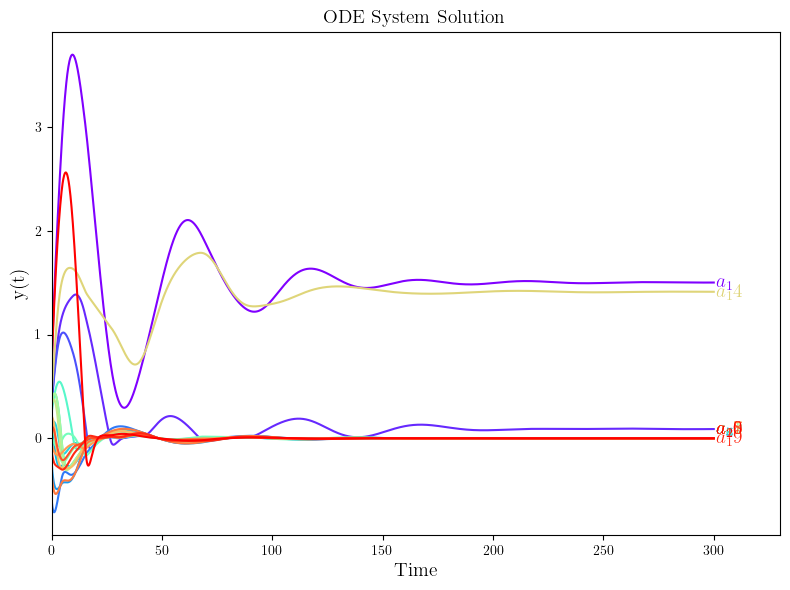

Weight vector w: [ 1.57559451 -0.7238518 ]
Bias term b: 0.42407044850481074
Number of support vectors: 3


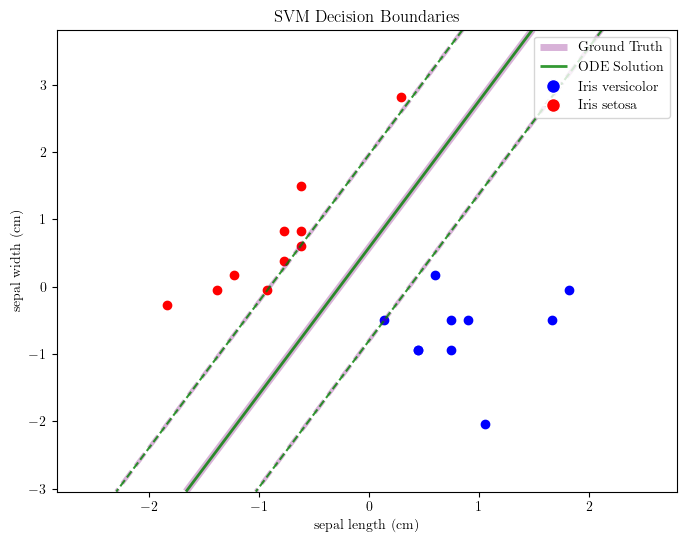

In [13]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nx].set(1.0)

sol, result = solve_ODE(xu0, 300)

t_values = sol.t
y_values = sol.y

plot_ode_system(t_values, y_values)

w_ode, b_ode, sv_ode = alpha_to_wb(result[:nx], selected_X, selected_y)
print(f"Weight vector w: {w_ode}")
print(f"Bias term b: {b_ode}")
print(f"Number of support vectors: {np.sum(sv_ode)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_op, b_op, w_ode, b_ode, 0, 1)

In [14]:
t0 = time.time()
sol, result = solve_ODE(xu0, 20)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [ 2.02148509  0.71783364 -0.05117316 -0.04753077  0.00088945 -0.02231248
 -0.01581675 -0.02314017 -0.01461261 -0.06490795  0.00635346 -0.02314012
 -0.01202691  1.27151287 -0.0116044  -0.03169071 -0.00983169  0.0008143
  0.01259882 -0.04187599]
Constraints: [-2.021485   -0.71783364  0.05117316  0.04753077 -0.00088945  0.02231248
  0.01581675  0.02314017  0.01461261  0.06490795 -0.00635346  0.02314012
  0.01202691 -1.2715129   0.0116044   0.03169071  0.00983169 -0.0008143
 -0.01259882  0.04187599]
max diff: 0.62727875 mean diff: 0.62727875
Time: 1.4313244819641113


In [15]:
t0 = time.time()
sol, result = solve_ODE(xu0, 50)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [ 1.51657498  0.18317348 -0.00475392 -0.00919573 -0.01024089 -0.00575941
 -0.00545594 -0.00407786 -0.00461517 -0.00272911 -0.00741515 -0.00407785
 -0.00505749  1.32297707 -0.00589825 -0.00566803 -0.010102   -0.0069253
 -0.00958647 -0.00316383]
Constraints: [-1.516575   -0.18317348  0.00475392  0.00919573  0.01024089  0.00575941
  0.00545594  0.00407786  0.00461517  0.00272911  0.00741515  0.00407785
  0.00505749 -1.3229771   0.00589825  0.00566803  0.010102    0.0069253
  0.00958647  0.00316383]
max diff: 0.09261857 mean diff: 0.09261857
Time: 3.389075756072998


In [16]:
t0 = time.time()
sol, result = solve_ODE(xu0, 100)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Dual variables (alpha): [ 1.33844829  0.11340766  0.00005779  0.00998369  0.01228425  0.00787107
  0.00033513  0.00645169 -0.00037462 -0.00338492  0.00261924  0.00645169
  0.00759379  1.29634869  0.00830348  0.00004131  0.01185201  0.00204827
  0.00460963  0.00646813]
Constraints: [-1.3384483  -0.11340766 -0.00005779 -0.00998369 -0.01228425 -0.00787107
 -0.00033513 -0.00645169  0.00037462  0.00338492 -0.00261924 -0.00645169
 -0.00759379 -1.2963487  -0.00830348 -0.00004131 -0.01185201 -0.00204827
 -0.00460963 -0.00646813]
max diff: 0.16477966 mean diff: 0.16477966
Time: 6.404203414916992


In [17]:
t0 = time.time()
sol, result = solve_ODE(xu0, 500)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: -1.5032238
Dual variables (alpha): [ 1.50322747  0.09050722  0.00000031  0.00000115 -0.00000007  0.00000044
  0.00000059  0.00000047  0.00000059  0.0000019   0.00000004  0.00000047
  0.00000018  1.41271853  0.00000018  0.00000099  0.00000016  0.00000019
 -0.00000006 -0.00000023]
Constraints: [-1.5032275  -0.09050722 -0.00000031 -0.00000115  0.00000007 -0.00000044
 -0.00000059 -0.00000047 -0.00000059 -0.0000019  -0.00000004 -0.00000047
 -0.00000018 -1.4127185  -0.00000018 -0.00000099 -0.00000016 -0.00000019
  0.00000006  0.00000023]
max diff: 4.7683716e-05 mean diff: 4.7683716e-05
Time: 31.27365779876709


In [18]:
t0 = time.time()
sol, result = solve_ODE(xu0, 1000)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: -1.5032241
Dual variables (alpha): [1.50323009 0.09051468 0.0000002  0.00000051 0.00000043 0.00000025
 0.00000029 0.00000021 0.00000029 0.00000055 0.00000025 0.0000002
 0.0000002  1.41271555 0.00000023 0.00000036 0.00000041 0.00000028
 0.00000031 0.00000007]
Constraints: [-1.5032301  -0.09051468 -0.0000002  -0.00000051 -0.00000043 -0.00000025
 -0.00000029 -0.00000021 -0.00000029 -0.00000055 -0.00000025 -0.0000002
 -0.0000002  -1.4127156  -0.00000023 -0.00000036 -0.00000041 -0.00000028
 -0.00000031 -0.00000007]
max diff: 4.0225685e-05 mean diff: 4.0225685e-05
Time: 61.27041816711426


In [12]:
w_ode, b_ode, sv_ode = alpha_to_wb(result[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_ode}")
print(f"Bias term b: {b_ode}")
print(f"Number of support vectors: {np.sum(sv_ode)}")

# 3. The method

In [19]:
T=300.0

In [20]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [21]:
y0 = np.zeros(NY)
y0[:nx] = 1.0

In [22]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

LAYERS: 1 NEURONS: 100 LR: 0.01 epsilon: 93.01259 MSE solution: 1.2575791385176969 time: 105.84209489822388
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 42.410843 MSE solution: 0.8904449127907536 time: 99.923024892807
LAYERS: 3 NEURONS: 100 LR: 0.01 epsilon: 63.044186 MSE solution: 0.9282442023733865 time: 102.22043514251709
LAYERS: 4 NEURONS: 100 LR: 0.01 epsilon: 91.33889 MSE solution: 1.4398528511565223 time: 99.7332022190094
LAYERS: 5 NEURONS: 100 LR: 0.01 epsilon: 72.79303 MSE solution: 0.9959179905646147 time: 107.09492611885071


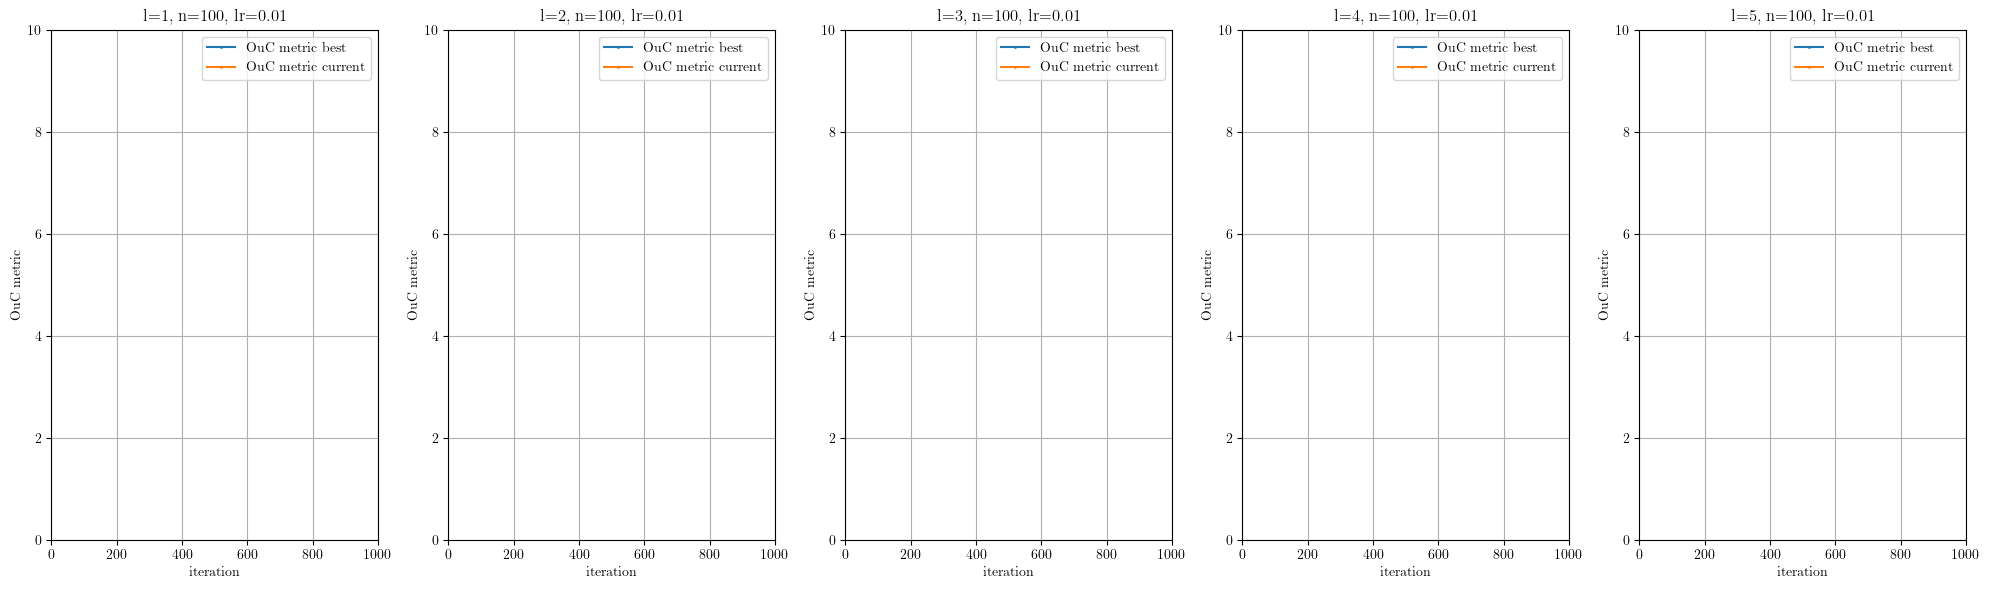

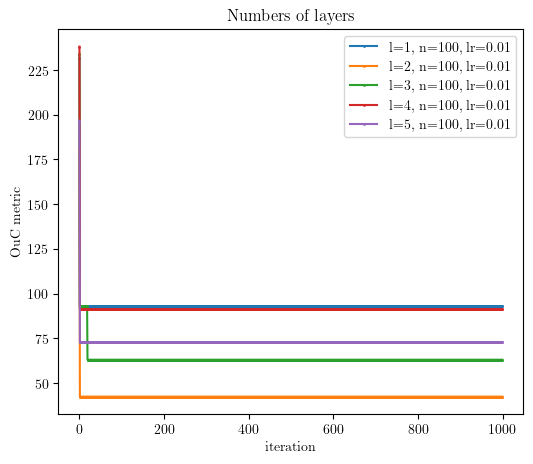

In [23]:
T=300.0
NBATCH = 512
ITERATIONS = 1000
WEIGTHING = 3
NEURONS=100
LR=0.01
LAYERS=2
res_layers = try_layers([1, 2, 3, 4, 5], 100, 0.01)
plot_results(res_layers, y_max=10)
plot_result_confrontation(res_layers)

LAYERS: 2 NEURONS: 50 LR: 0.01 epsilon: 85.936035 MSE solution: 2.195822433121812 time: 111.03061532974243
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 68.910995 MSE solution: 0.9825681539835429 time: 109.78037333488464
LAYERS: 2 NEURONS: 200 LR: 0.01 epsilon: 19.778042 MSE solution: 0.8294370967834238 time: 109.87796998023987
LAYERS: 2 NEURONS: 300 LR: 0.01 epsilon: 65.19668 MSE solution: 0.8879349363529238 time: 106.43559122085571
LAYERS: 2 NEURONS: 400 LR: 0.01 epsilon: 29.716938 MSE solution: 0.4778328576889073 time: 108.7923755645752


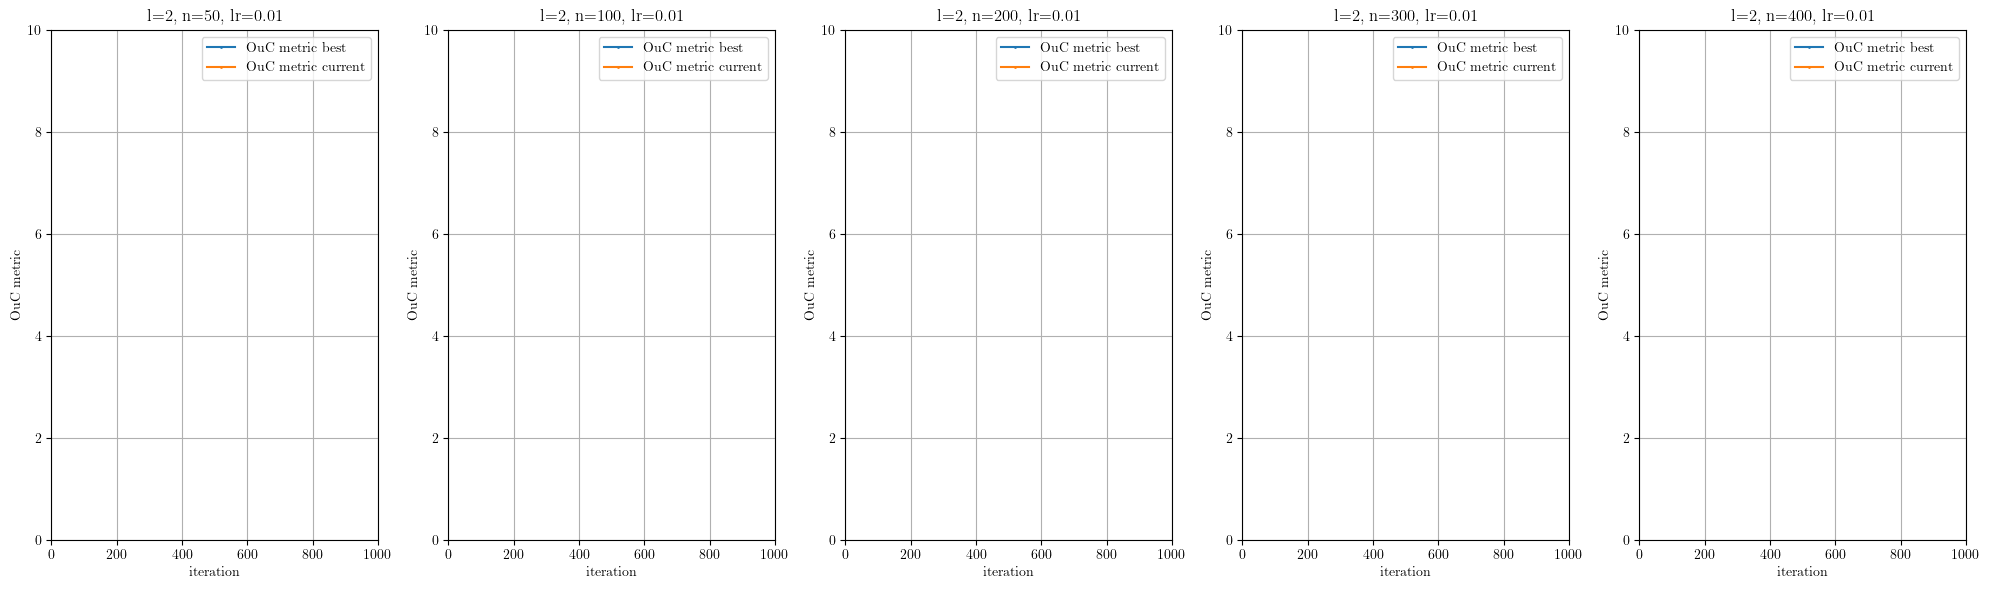

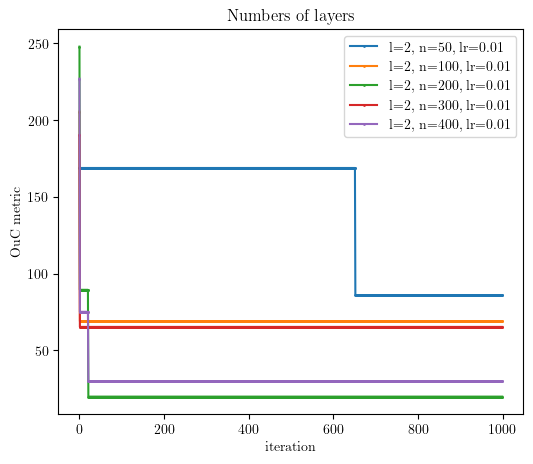

In [24]:
res_neurons = try_neurons([50, 100, 200, 300, 400], 2, 0.01)
plot_results(res_neurons, y_max=10)
plot_result_confrontation(res_neurons)

LAYERS: 2 NEURONS: 100 LR: 0.0001 epsilon: 58.93021 MSE solution: 1.0185566984682575 time: 105.26892066001892
LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 41.49455 MSE solution: 0.5509032506946341 time: 109.78393602371216
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 66.4483 MSE solution: 1.4987606541912477 time: 110.26509356498718
LAYERS: 2 NEURONS: 100 LR: 0.1 epsilon: 19.684994 MSE solution: 0.7697933799773541 time: 109.55271625518799


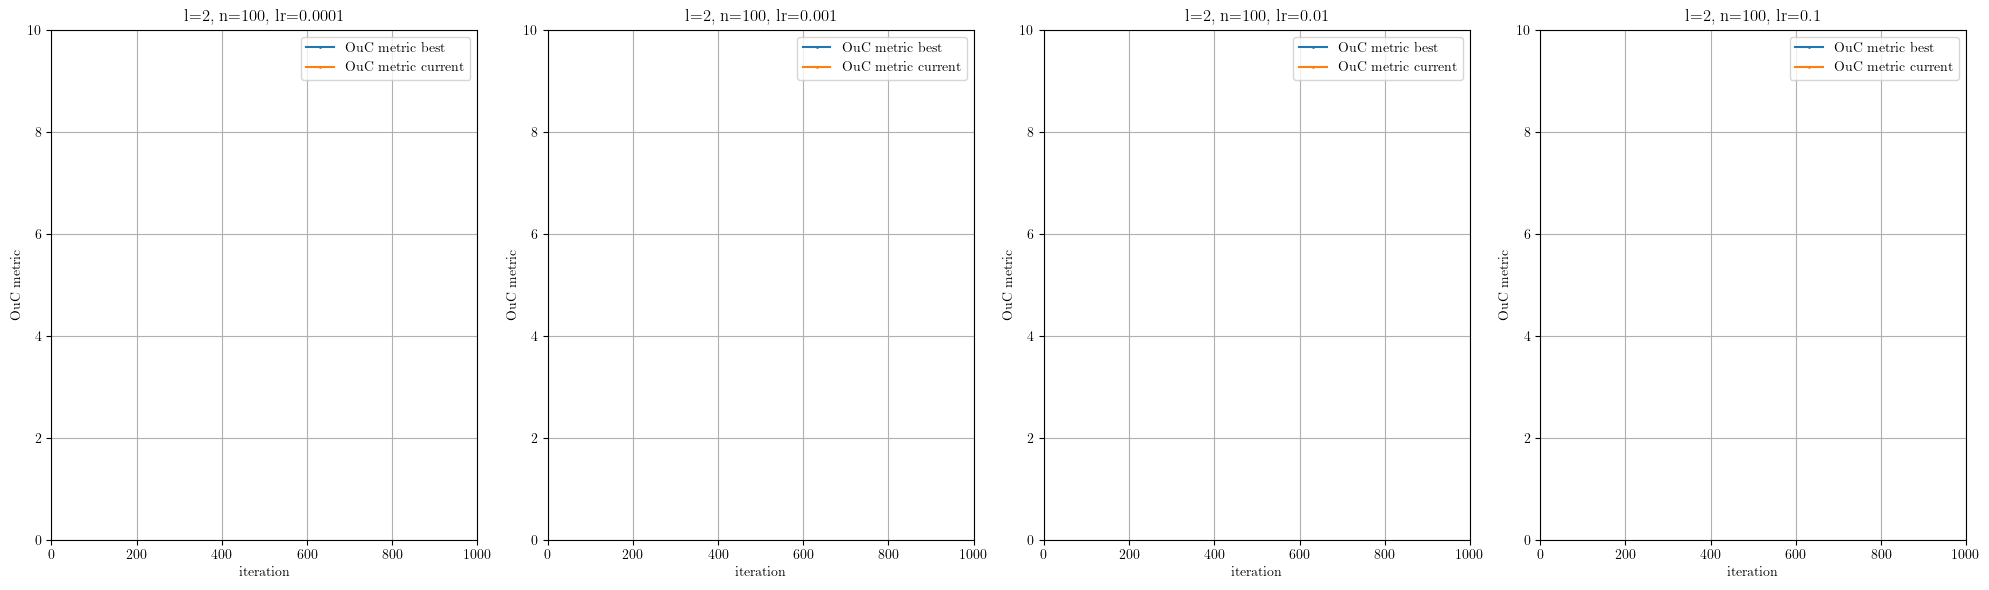

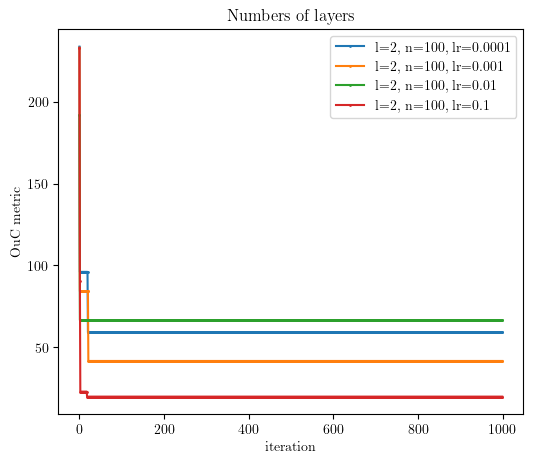

In [25]:
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 2, 100)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

Weight vector w: [ 7.53542168 -6.88699149]
Bias term b: -7.549516567451064e-15
Number of support vectors: 20


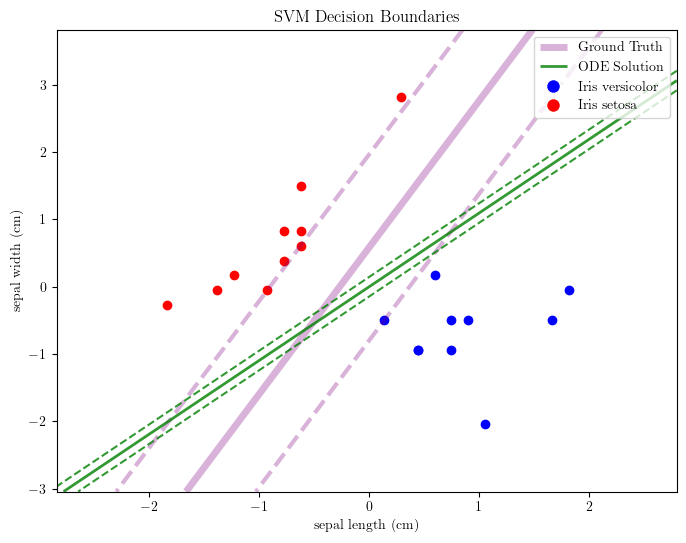

Variables: [0.33742845 0.3430106  0.41489583 0.16188991 0.12368536 0.86753786
 0.8646685  0.65359294 0.55988157 0.4371003  0.37872255 0.98689914
 0.37618935 0.16495955 0.5593849  0.3892449  0.6855815  0.4523018
 0.26544303 0.6733549 ]
Constraints: [-0.33742845 -0.3430106  -0.41489583 -0.16188991 -0.12368536 -0.86753786
 -0.8646685  -0.65359294 -0.55988157 -0.4371003  -0.37872255 -0.98689914
 -0.37618935 -0.16495955 -0.5593849  -0.3892449  -0.6855815  -0.4523018
 -0.26544303 -0.6733549 ]


In [26]:
net = res_layers[1]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

Weight vector w: [ 5.25066919 -5.30803952]
Bias term b: 0.46377806899254675
Number of support vectors: 19


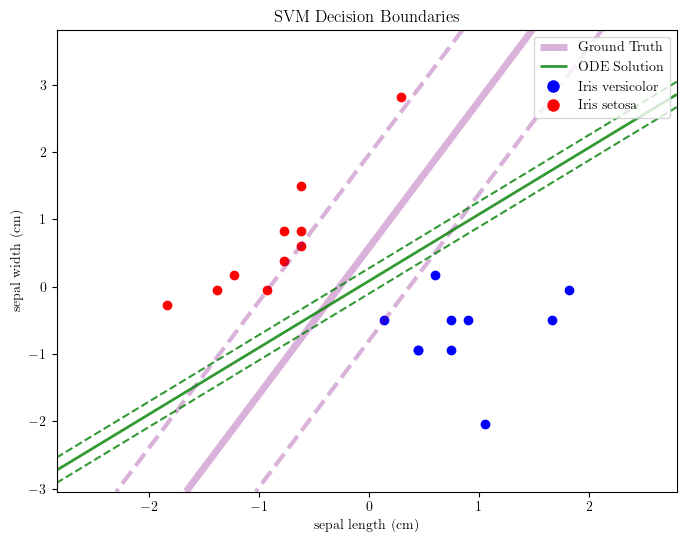

Variables: [ 1.0350009   0.7580296   0.41419876  0.07935774 -0.00234461  0.37574536
  0.60126317  0.6196641   0.22518235  0.4490853   0.3694889   0.4803446
  0.12002665  0.34474897  0.11485374  0.39294934  0.24867243  0.43859214
  0.1228618   0.9066447 ]
Constraints: [-1.0350009  -0.7580296  -0.41419876 -0.07935774  0.00234461 -0.37574536
 -0.60126317 -0.6196641  -0.22518235 -0.4490853  -0.3694889  -0.4803446
 -0.12002665 -0.34474897 -0.11485374 -0.39294934 -0.24867243 -0.43859214
 -0.1228618  -0.9066447 ]


In [27]:
net = res_neurons[2]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

Weight vector w: [ 6.42432505 -3.84228596]
Bias term b: -0.9858109916218818
Number of support vectors: 18


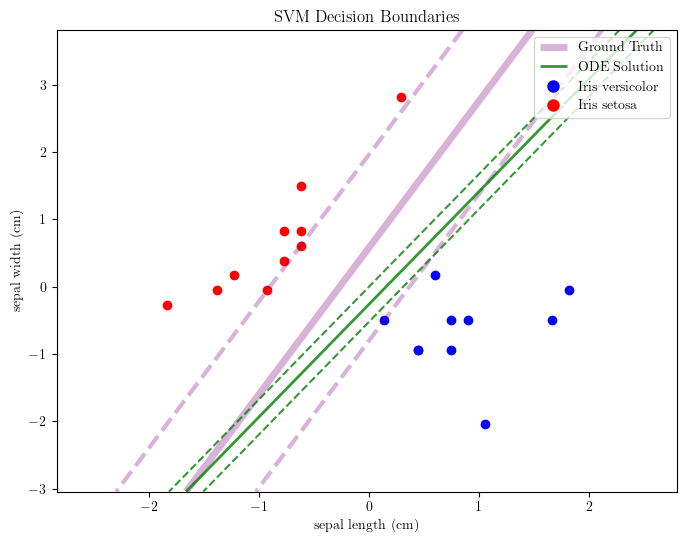

Variables: [ 0.99035436  0.676788    0.35277987  0.35802674  0.35057324  0.41474742
  0.09954101  0.3717577   0.2561258  -0.05218554  0.7224659   0.2613085
  0.3099681   0.45371914  0.47531146  0.4647594   0.2123552   0.17553633
 -0.04627287  1.4849051 ]
Constraints: [-0.99035436 -0.676788   -0.35277987 -0.35802674 -0.35057324 -0.41474742
 -0.09954101 -0.3717577  -0.2561258   0.05218554 -0.7224659  -0.2613085
 -0.3099681  -0.45371914 -0.47531146 -0.4647594  -0.2123552  -0.17553633
  0.04627287 -1.4849051 ]


In [28]:
net = res_learning_rate[3]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

In [30]:
LAYERS = 2
NEURONS = 100
LR = 0.01
ITERATIONS=3000
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, t = example.NN_method() # train
mse_ = get_error({'net': net_best})
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', t)
res = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time}

LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 12.790203 MSE solution: 0.8119391341317215 time: 354.4665400981903


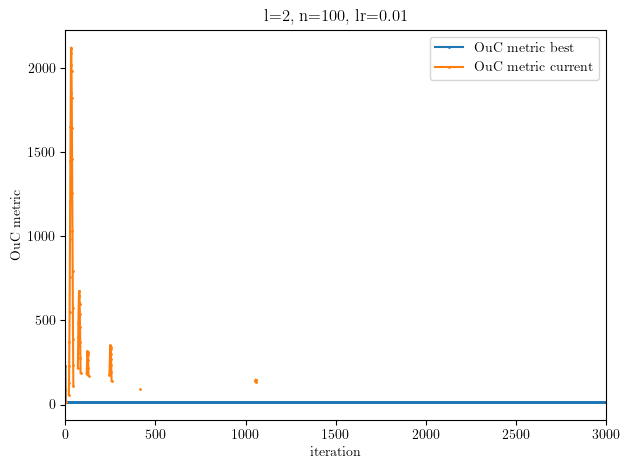

In [31]:
plt.plot(res['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

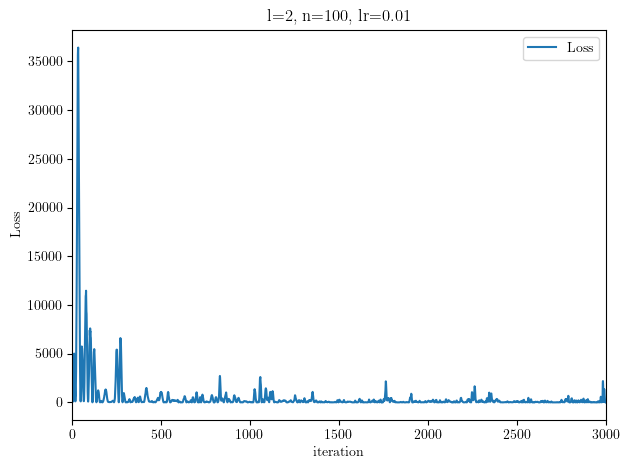

In [32]:
plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

Weight vector w: [ 4.75765442 -3.84338666]
Bias term b: 0.2479273073238288
Number of support vectors: 19


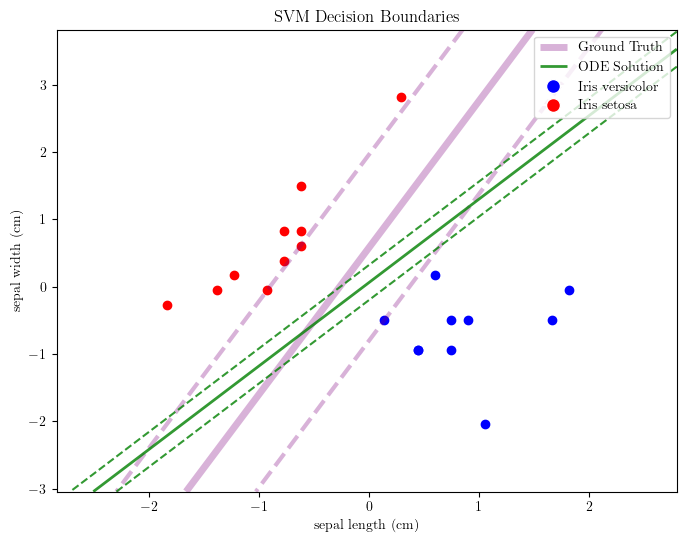

Variables: [ 0.2966559   0.11732233  0.7283064   0.453591    0.07384694  0.07292628
  0.52504295  0.12342942  0.6078975   0.1938228   0.20101053 -0.01684594
  0.4600364   0.46008098  0.04918534  0.38356525  0.0749293   0.41872418
  0.2000584   0.48966157]
Constraints: [-0.2966559  -0.11732233 -0.7283064  -0.453591   -0.07384694 -0.07292628
 -0.52504295 -0.12342942 -0.6078975  -0.1938228  -0.20101053  0.01684594
 -0.4600364  -0.46008098 -0.04918534 -0.38356525 -0.0749293  -0.41872418
 -0.2000584  -0.48966157]


In [33]:
net = res['net']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()

w_pinn, b_pinn, sv_pinn = alpha_to_wb(res_[:nx], selected_X, selected_y)

print(f"Weight vector w: {w_pinn}")
print(f"Bias term b: {b_pinn}")
print(f"Number of support vectors: {np.sum(sv_pinn)}")

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w_ode, b_ode, w_pinn, b_pinn, 0, 1)
print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))